# KNN, рак и спам

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

from collections import Counter

np.set_printoptions(suppress=True)

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
class StdScaler:  # sklearn is banned.

    def __init__(self):
        self.mean_ = None
        self.std_ = None
        
    def fit(self, X):
        X = pd.DataFrame(X)

        self.mean_ = np.mean(X)
        self.std_ = np.std(X)
        
        return self

    def transform(self, X):
        X = X.copy()

        for j, row in enumerate(X):
            for i, col in enumerate(row):
                
                X[j, i] = (X[j, i] - (self.mean_[i])) / self.std_[i]

        return X

In [3]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    
    return df.drop(columns=['label']).to_numpy(), df['label'].apply(lambda x: 1 if x == 'M' else 0).to_numpy()


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """

    df = pd.read_csv(path_to_csv).sample(frac=1)

    return df.drop(columns=['label']).to_numpy(), df['label'].to_numpy()


### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """

    train_size = round(X.shape[0] * ratio)
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """

    TP = Counter()
    FP = Counter()
    FN = Counter()
    
    classes = np.unique(y_true)

    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            TP[y_true[i]] += 1
        else:
            FP[y_pred[i]] += 1
            FN[y_true[i]] += 1

    precision = [TP[a_class] / (TP[a_class] + FP[a_class]) if TP[a_class] + FP[a_class] != 0 else 0 for a_class in
                 classes]  # How many SELECTED items are RELEVANT
    recall = [TP[a_class] / (TP[a_class] + FN[a_class]) if TP[a_class] + FN[a_class] != 0 else 0 for a_class in
              classes]  # How many RELEVANT items are SELECTED
    accuracy = sum(TP.values()) / len(y_true)  # Multiclass classification TN = 0

    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)

    def plot(x, ys, ylabel, legend=True):
        plt.figure(figsize=(12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys) - 0.01, np.max(ys) + 0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()

    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize=(7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.


Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40, depth=0):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        if not isinstance(X[0], tuple):
            X = list(zip(X, [i for i in range(len(X))]))

        self.dimension = depth
        X = sorted(X, key=lambda z: z[0][self.dimension])
        mid_index = len(X) // 2

        if len(X) < 2 * leaf_size or X[0][0][self.dimension] == X[len(X) - 1][0][self.dimension]:
            self.points = X
            return

        self.coord = X[mid_index][0][self.dimension]
        self.left = KDTree(X[:mid_index], leaf_size, (self.dimension + 1) % len(X[0][0]))
        self.right = KDTree(X[mid_index:], leaf_size, (self.dimension + 1) % len(X[0][0]))
        
    @staticmethod
    def __max_distance__(nearest_neighbors, x):
        return np.linalg.norm(nearest_neighbors[len(nearest_neighbors) - 1][0] - x)
    
    @staticmethod
    def __merge__(fst, snd, x, k):
        result = []
        i = 0
        j = 0
        
        while i < len(fst) and j < len(snd) and len(result) < k:
            if np.linalg.norm(fst[i][0] - x) < np.linalg.norm(snd[j][0] - x):
                result.append(fst[i])
                i += 1
            else:
                result.append(snd[j])
                j += 1

        while i < len(fst) and len(result) < k:
            result.append(fst[i])
            i += 1

        while j < len(snd) and len(result) < k:
            result.append(snd[j])
            j += 1

        return result


    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """

        return [list(map(lambda e: e[1], self.query_one_point(x, k))) for x in X]
    
    def query_one_point(self, x, k: int = 1) -> List:
        if not hasattr(self, 'left'):
            return sorted(self.points, key=lambda z: np.linalg.norm(z[0] - x))[:k]

        list_for_merge = []
        if x[self.dimension] < self.coord:

            nearest_neighbors = self.left.query_one_point(x, k)
            if len(nearest_neighbors) < k or KDTree.__max_distance__(nearest_neighbors, x) >= self.coord - x[self.dimension]:
                list_for_merge = self.right.query_one_point(x, k)
        else:
            nearest_neighbors = self.right.query_one_point(x, k)
            if len(nearest_neighbors) < k or KDTree.__max_distance__(nearest_neighbors, x) >= x[self.dimension] - self.coord:
                list_for_merge = self.left.query_one_point(x, k)

        return KDTree.__merge__(nearest_neighbors, list_for_merge, x, k)

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result


X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)  # убрал return_distance, видимо это что-то старое
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.kd_tree = None
        self.y = None

    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """
        self.kd_tree = KDTree(X, self.leaf_size)
        self.y = y

    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        knn = self.kd_tree.query(X, k=self.n_neighbors)

        result = []
        from collections import Counter

        for neighbors in knn:
            classes_counter = Counter(map(lambda index: self.y[index], neighbors))
            lst = [0] * 2
            for elem, freq in classes_counter.items():
                lst[elem] = freq / len(neighbors)

            result.append(lst)

        return result

    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

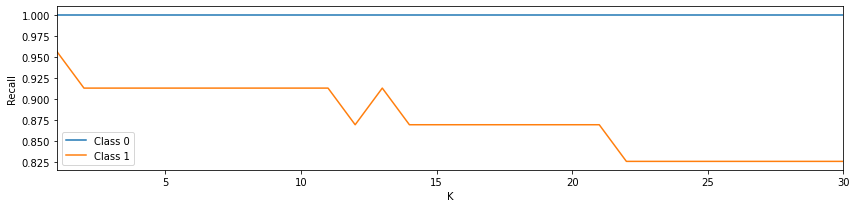

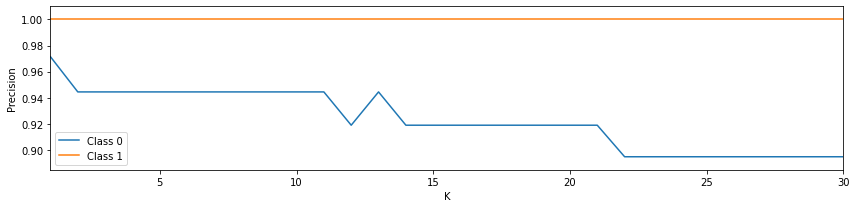

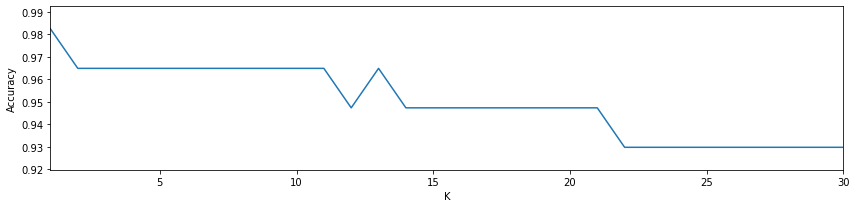

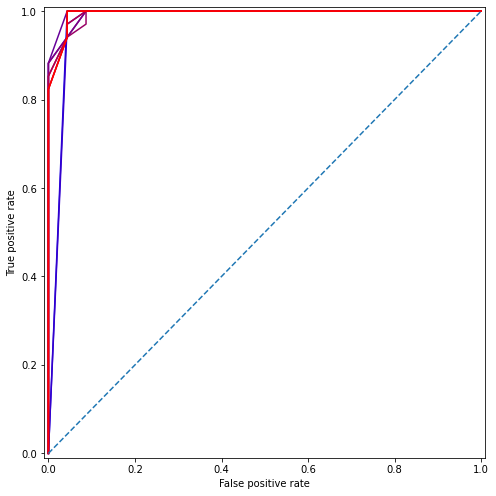

In [11]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

scaler = StdScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

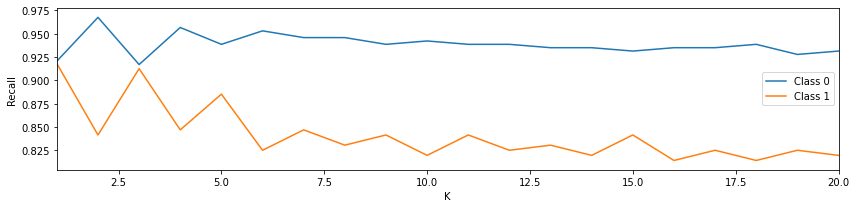

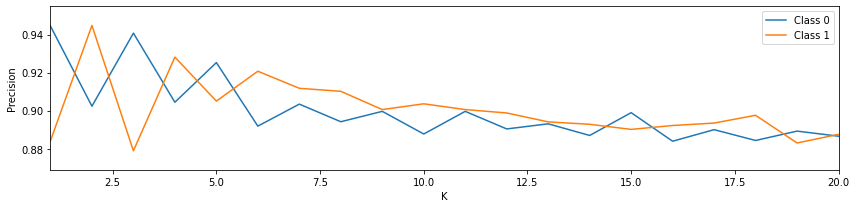

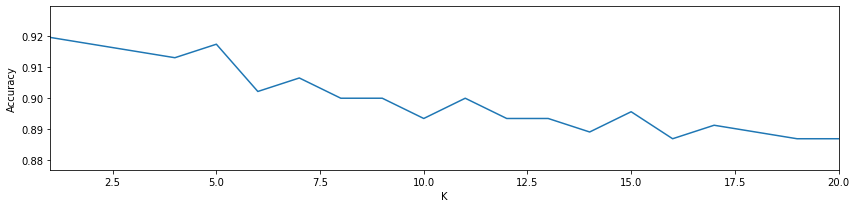

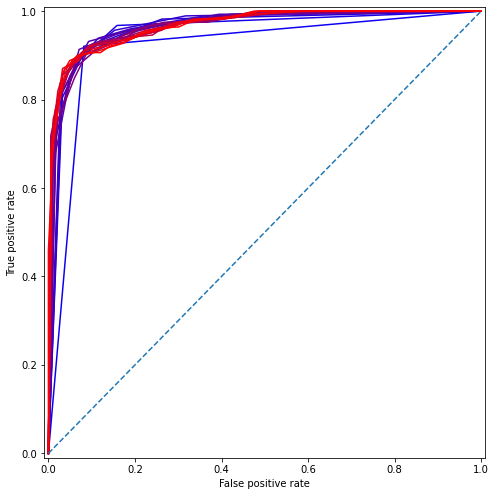

In [12]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

scaler = StdScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)